#Team members:
#####1. Uma Pavan Kumar Chukkapalli 
#####2. Vinay Kumar  Mannem
#####3. Irits Anna Mathew
#####4. Nithya Sheena Sham Sundar


Path for dataset: 'https://github.com/umapavanc/unsupervised/blob/main/umist_cropped.mat'

Part1: Load the raw dataset and perform exploratory data analaysis

In [1]:
# Required to run bisect kmeans algorithm
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 26.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [3]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 25.4 MB/s 
     |████████████████████████████████| 1.6 MB 56.6 MB/s 


In [4]:
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

raw=true in github URL will download actual file instrad of web page. 
wget is command-line tool that will allow download files.

In [5]:
!wget https://github.com/umapavanc/unsupervised/blob/main/umist_cropped.mat?raw=true

--2022-12-17 21:39:17--  https://github.com/umapavanc/unsupervised/blob/main/umist_cropped.mat?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/umapavanc/unsupervised/raw/main/umist_cropped.mat [following]
--2022-12-17 21:39:17--  https://github.com/umapavanc/unsupervised/raw/main/umist_cropped.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/umapavanc/unsupervised/main/umist_cropped.mat [following]
--2022-12-17 21:39:18--  https://raw.githubusercontent.com/umapavanc/unsupervised/main/umist_cropped.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP req

rename the file

In [6]:
!mv umist_cropped.mat\?raw\=true umist_cropped.mat

Load the .mat format dataset using scipy.io.loadmat function

In [7]:
dataset = io.loadmat('umist_cropped.mat')

dataset -> output type is dictionary
dataset.keys() -> dict_keys(['__header__', '__version__', '__globals__', 'facedat', 'dirnames']). 
type(dataset['facedat']), dataset['facedat'].shape: (numpy.ndarray, (1, 20))

In [8]:
for i in range(20):
  print(type(dataset['facedat'][0][i]), dataset['facedat'][0][i].shape)

<class 'numpy.ndarray'> (112, 92, 38)
<class 'numpy.ndarray'> (112, 92, 35)
<class 'numpy.ndarray'> (112, 92, 26)
<class 'numpy.ndarray'> (112, 92, 24)
<class 'numpy.ndarray'> (112, 92, 26)
<class 'numpy.ndarray'> (112, 92, 23)
<class 'numpy.ndarray'> (112, 92, 19)
<class 'numpy.ndarray'> (112, 92, 22)
<class 'numpy.ndarray'> (112, 92, 20)
<class 'numpy.ndarray'> (112, 92, 32)
<class 'numpy.ndarray'> (112, 92, 34)
<class 'numpy.ndarray'> (112, 92, 34)
<class 'numpy.ndarray'> (112, 92, 26)
<class 'numpy.ndarray'> (112, 92, 30)
<class 'numpy.ndarray'> (112, 92, 19)
<class 'numpy.ndarray'> (112, 92, 26)
<class 'numpy.ndarray'> (112, 92, 26)
<class 'numpy.ndarray'> (112, 92, 33)
<class 'numpy.ndarray'> (112, 92, 48)
<class 'numpy.ndarray'> (112, 92, 34)


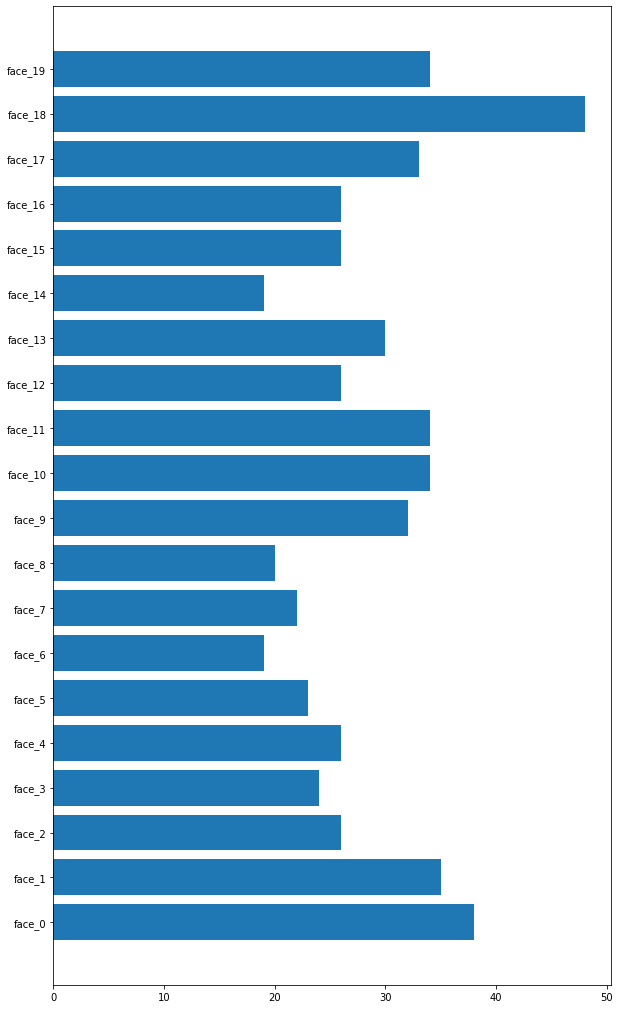

In [9]:
# Check if the dataset is imbalanced
len(dataset['facedat'][0])
values = [dataset['facedat'][0][i].shape[2] for i in range(len(dataset['facedat'][0]))]
keys = [f"face_{i}" for i in range(len(dataset['facedat'][0]))]

f, ax = plt.subplots(figsize=(10,18))
plt.barh(keys, values)
plt.show()

In [10]:
dataset['__header__']

b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Wed Aug 28 11:38:19 2002'

In [11]:
#dataset['dirnames'].shape -> (1, 20)
dataset['dirnames']

array([[array(['1a'], dtype='<U2'), array(['1b'], dtype='<U2'),
        array(['1c'], dtype='<U2'), array(['1d'], dtype='<U2'),
        array(['1e'], dtype='<U2'), array(['1f'], dtype='<U2'),
        array(['1g'], dtype='<U2'), array(['1h'], dtype='<U2'),
        array(['1i'], dtype='<U2'), array(['1j'], dtype='<U2'),
        array(['1k'], dtype='<U2'), array(['1l'], dtype='<U2'),
        array(['1m'], dtype='<U2'), array(['1n'], dtype='<U2'),
        array(['1o'], dtype='<U2'), array(['1p'], dtype='<U2'),
        array(['1q'], dtype='<U2'), array(['1r'], dtype='<U2'),
        array(['1s'], dtype='<U2'), array(['1t'], dtype='<U2')]],
      dtype=object)

Images of all 20 unique face. Total images count: 575 and each image width is 112 and height is 92.
The Sheffield (previously UMIST) Face Database consists of 575 images of 20 individuals (mixed race/gender/appearance). Each individual is shown in a range of poses 
from profile to frontal views - each in a separate directory labelled 1a, 1b, ... 1t and images are numbered consecutively as they were taken


In [12]:
list_ = []
facedat = dataset['facedat'] # Shape (1,20)

for i in range(facedat.shape[1]):
  temp = facedat[0][i]
  for j in range(temp.shape[2]):
    list_.append(temp[:,:,j])
data = np.array(list_)
data.shape

(575, 112, 92)

##Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set. Provide your rationale for the split ratio [5 points]



In [13]:
from sklearn.model_selection import ShuffleSplit

strat_split = ShuffleSplit(n_splits=5, test_size=0.1, random_state=9)
train_idx, test_idx = next(strat_split.split(data))
x_train_full = data[train_idx]
x_test = data[test_idx]

strat_split = ShuffleSplit(n_splits=5, test_size=0.1, random_state=9)
train_idx_, test_idx_ = next(strat_split.split(x_train_full))
x_train = x_train_full[train_idx_]
x_valid = x_train_full[test_idx_]

print("Shape of training dataset: ", x_train.shape)
print("Shape of testing dataset: ", x_test.shape)
print("Shape of validation dataset: ", x_valid.shape)

Shape of training dataset:  (465, 112, 92)
Shape of testing dataset:  (58, 112, 92)
Shape of validation dataset:  (52, 112, 92)


Number of images for each person i.e., label vs count

##Discuss the rationale behind how your team preprocess the data. Include the mathematical equations used and any dimensionality reduction applied to the instanced and discuss its relevance to the problem at hand. Note that your team will receive more points if you perform data preprocessing that help improve the eventual training process. [20 points]

function to perform Standardization

In [14]:
def standardization(x):
  scaler = StandardScaler()
  scaler.fit(x)
  #x_mean = scaler.mean_
  #x_std = scaler.scale_
  #x = (x-x_mean)/x_std
  x = scaler.transform(x)
  return x

Normalize the data i.e, pixel values are between 0 and 1
Flatten the image i.e., 2D array -> 1D array
Standardization: Standardize features by removing the mean and scaling to unit variance. 

In [15]:
def preprocess(x):
  #x = x/255
  nPixel = x.shape[1]*x.shape[2]
  print(x.shape, nPixel)
  x = x.reshape(x.shape[0],nPixel).astype('float32')
  x = standardization(x)
  return x;

In [16]:
x_train_ = preprocess(x_train)
x_test_ = preprocess(x_test)
x_valid_ = preprocess(x_valid)

print("Shape of transformed training dataset: ", x_train_.shape)
print("Shape of transformed testing dataset: ", x_test_.shape)
print("Shape of transformed validation dataset: ", x_valid_.shape)

(465, 112, 92) 10304
(58, 112, 92) 10304
(52, 112, 92) 10304
Shape of transformed training dataset:  (465, 10304)
Shape of transformed testing dataset:  (58, 10304)
Shape of transformed validation dataset:  (52, 10304)


In [17]:
x_train_[0]

array([-0.2536363 , -0.24422295, -0.22056687, ..., -0.20040151,
       -0.23955362, -0.34382233], dtype=float32)

In [18]:
def plotImages(x, y=None):
  plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      if y is not None:
        plt.title(y[i])
      plt.imshow(x[i])

  plt.show()

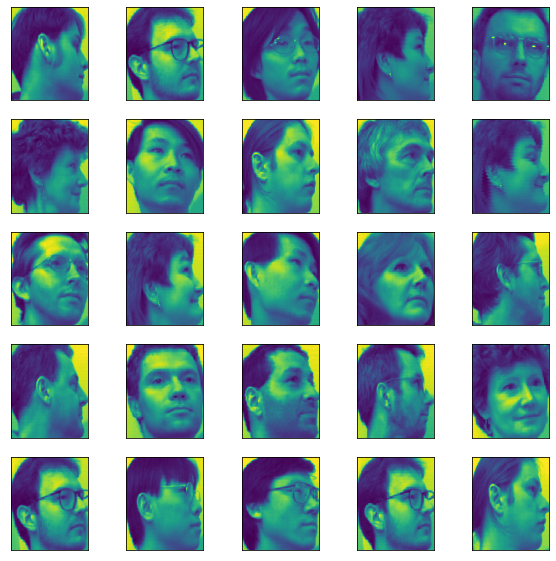

In [19]:
plotImages(x_train[:25])

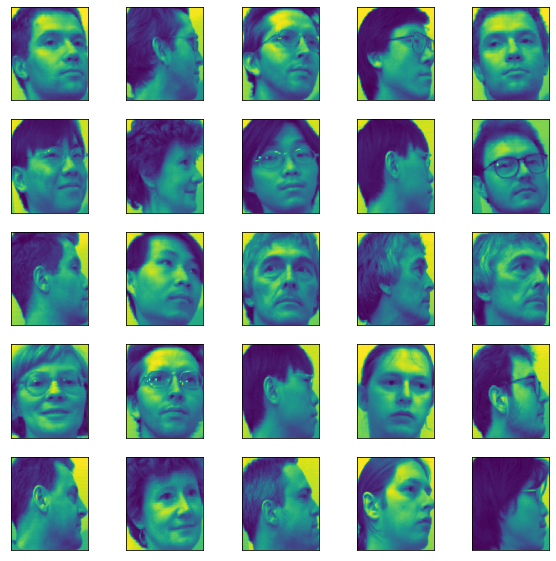

In [20]:
plotImages(x_test[:25])

In [21]:
# Reducing the dimensions of the train data:
from sklearn.decomposition import PCA    
pca = PCA(n_components = min(x_train_.shape), whiten = False, random_state = 42).fit(x_train_)

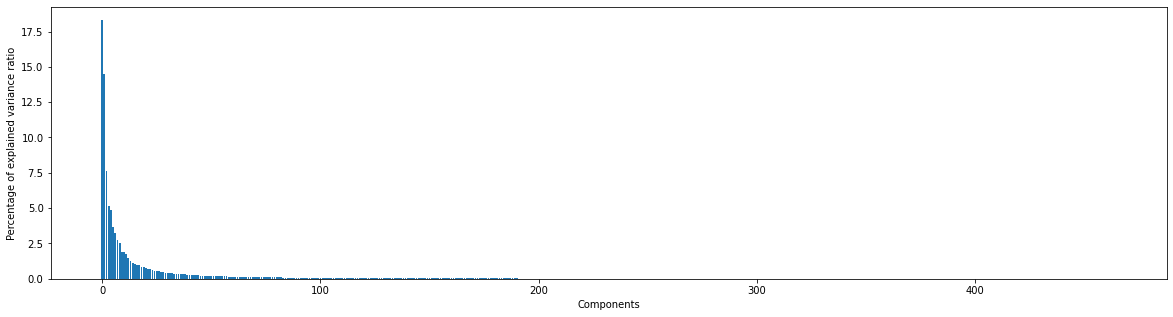

In [20]:
plt.figure(figsize = (20,5))
plt.xlabel("Components")
plt.ylabel("Percentage of explained variance ratio")
plt.bar(list(range(pca.n_components_)), list(pca.explained_variance_ratio_*100))
plt.show()

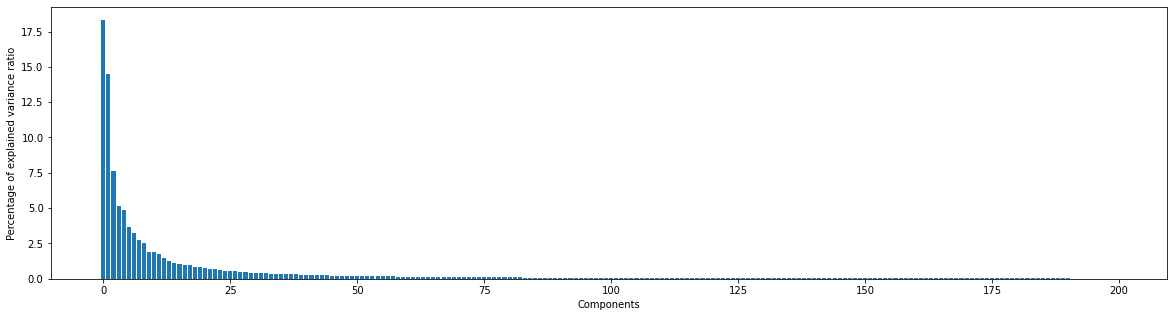

In [21]:
plt.figure(figsize = (20,5))
plt.xlabel("Components")
plt.ylabel("Percentage of explained variance ratio")
plt.bar(list(range(pca.n_components_))[:200], list(pca.explained_variance_ratio_*100)[:200])
plt.show()

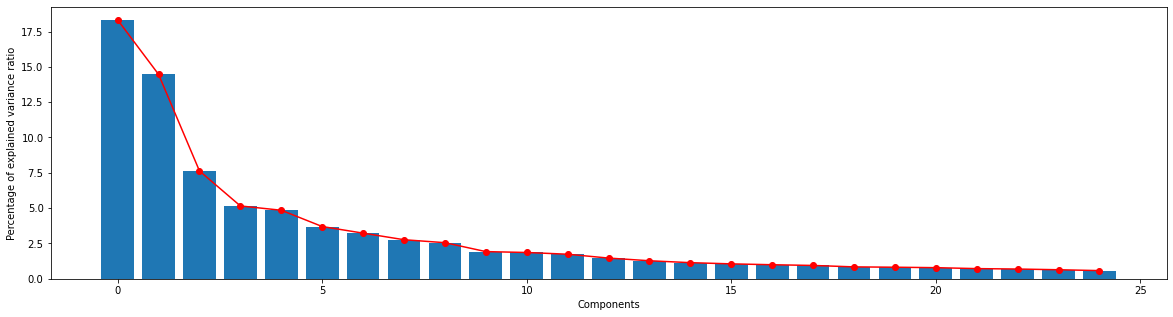

In [22]:
plt.figure(figsize = (20,5))
plt.xlabel("Components")
plt.ylabel("Percentage of explained variance ratio")
plt.bar(list(range(pca.n_components_))[:25], list(pca.explained_variance_ratio_*100)[:25])
plt.plot(list(range(pca.n_components_))[:25], list(pca.explained_variance_ratio_*100)[:25], 'o-r')
plt.show()

In [22]:
pca = PCA(n_components = 0.9, random_state = 42).fit(x_train_)
x_train_pca = pca.transform(x_train_)
x_valid_pca = pca.transform(x_valid_)
x_test_pca = pca.transform(x_test_)

print("Shape of reduced train data: ", x_train_pca.shape)
print("Shape of reduced valid data: ", x_valid_pca.shape)
print("Shape of reduced test data: ", x_test_pca.shape)

Shape of reduced train data:  (465, 59)
Shape of reduced valid data:  (52, 59)
Shape of reduced test data:  (58, 59)


##Select a clustering technique taught in this course and apply it on the training instances. Provide the rationale behind your team’s choice of clustering technique and how your team tuned the parameters for the technique implemented. [30 points]

###KMeans Clustering and Silhouette Score

Uma Pavan Kumar Chukkapalli 

In [23]:
def bestK(kmeans_per_k, k_range, x):
  silhouette_scores = [silhouette_score(x, model.labels_) for model in kmeans_per_k]
  best_index = np.argmax(silhouette_scores)
  best_k = k_range[best_index]
  best_score = silhouette_scores[best_index]
  best_kmodel = kmeans_per_k[best_index]

  print("Number of clusters - ", best_k)
  print("Best score - ", best_score)

  plt.figure(figsize=(15, 5))
  plt.plot(k_range, silhouette_scores, "bo-")
  plt.xlabel("$k$", fontsize=14)
  plt.ylabel("Silhouette score", fontsize=14)
  plt.plot(best_k, best_score, "rs")
  plt.show()
  return best_kmodel

In [24]:
def kmeans(k_range = range(90, 150, 5), x = None):
  kmeans_per_k = []
  for k in k_range:
      print("k={}".format(k))
      kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10).fit(x)
      kmeans_per_k.append(kmeans)
  best_kmodel = bestK(kmeans_per_k, k_range, x)
  return best_kmodel 

In [25]:
x_train_pca.shape

(465, 59)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
Number of clusters -  45
Best score -  0.28926614


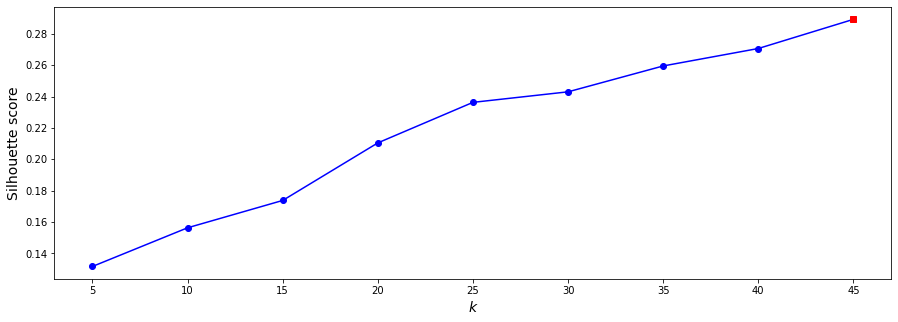

In [27]:
best_kmodel = kmeans(range(5, 50, 5), x = x_train_pca)

In [28]:
# Train, test and validation data lables using the best k value of K-means algorithm
kmeans_train_labels = best_kmodel.labels_
kmeans_valid_labels = best_kmodel.predict(x_valid_pca)
kmeans_test_labels = best_kmodel.predict(x_test_pca)

print("Shape of cluster index values for train data", kmeans_train_labels.shape) # Output cluster index value for trained data i.e., (439,1)
print("Shape of cluster index values for valid data", kmeans_valid_labels.shape)
print("Shape of cluster index values for test data", kmeans_test_labels.shape)

Shape of cluster index values for train data (465,)
Shape of cluster index values for valid data (52,)
Shape of cluster index values for test data (58,)


### Gaussian Mixture Model
Nithya Sheena Sham Sundar

In [29]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def gaussMix(x):
    #Trying to find the best n_component: 
    n_components = np.arange(1,x.shape[1])
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(x) for n in n_components]
    
    #computing BIC scores with scikit-learn:
    #checing for the first model:
    models[0].bic(x)
    
    #comparing how the BIC score change with respect to the no. of components:
    gmm_model_comparisons=pd.DataFrame({"n_components" : n_components, "BIC" : [m.bic(x) for m in models]})
    
    print(gmm_model_comparisons.head())
    minBIC= min(gmm_model_comparisons["BIC"])
    print(gmm_model_comparisons.iloc[gmm_model_comparisons[["BIC"]].idxmin()])

    #Plot of BIC vs the number components:    
    plt.figure(figsize=(8,6))
    sns.lineplot(data=gmm_model_comparisons[["BIC"]])
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")
    return models[gmm_model_comparisons["BIC"].argmin()]

   n_components            BIC
0             1  202783.568335
1             2  197464.263201
2             3  193018.691650
3             4  190970.957015
4             5  189010.009940
    n_components           BIC
20            21  96546.084891


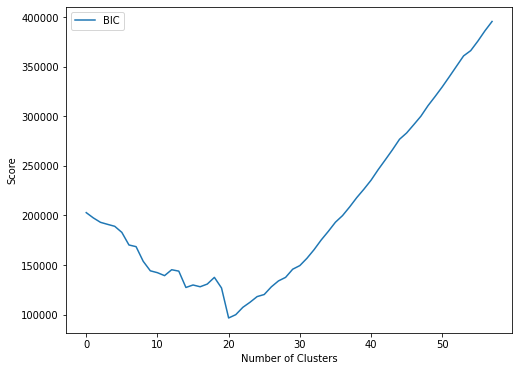

In [30]:
gaussClustering = gaussMix(x_train_pca)

In [31]:
# Train, test and validation data transform using the best k value of K-means algorithm
gc_train_labels = gaussClustering.predict(x_train_pca)
gc_valid_labels = gaussClustering.predict(x_valid_pca)
gc_test_labels = gaussClustering.predict(x_test_pca)

print("Shape of cluster index values for train data", gc_train_labels.shape) # Output cluster index value for trained data i.e., (439,1)
print("Shape of cluster index values for valid data", gc_valid_labels.shape)
print("Shape of cluster index values for test data", gc_test_labels.shape)

Shape of cluster index values for train data (465,)
Shape of cluster index values for valid data (52,)
Shape of cluster index values for test data (58,)


### Hierarchical Agglomerative Clustering
Vinay Kumar Mannem

In [34]:
def sihScore(x, labels):
    score = silhouette_score(x, labels)
    return score

In [35]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def AgglomerativeCluster(df, clusters = 50, affinity='euclidean', linkage='average'):
    Agglo_clf = AgglomerativeClustering(n_clusters = clusters, affinity = affinity, linkage = linkage)
    Agglo_clf.fit(df)
    labels = Agglo_clf.labels_
    return labels

def agglExecution(x, affinity, dist):
  scoresDict = dict()
  range_ = range(5, 50, 5)
  for j in range(0,3):
      rangeScores = []
      for i in range_:
          labels = AgglomerativeCluster(x, i, affinity = affinity[j]) #AgglomerativeCluster(x_train_pca, clusters = i, affinity = affinity[j])
          rangeScores.append(sihScore(x, labels))
      scoresDict[affinity[j]] = rangeScores

      vm_best_index = np.argmax(scoresDict[affinity[j]])
      vm_best_score = scoresDict[affinity[j]][vm_best_index]

      print("Number of clusters - ", range_[vm_best_index])
      print("Best score - ", vm_best_score)

      plt.figure(figsize=(8, 3))
      plt.title("Silhouette score of {} metric".format(affinity[j]), fontsize=14)
      plt.plot(range_, scoresDict[affinity[j]], "bo-")
      plt.xlabel("$k$", fontsize=14)
      plt.ylabel("Silhouette score", fontsize=14)
      plt.plot(range_[vm_best_index], vm_best_score, "rs")
      plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be remo

Number of clusters -  45
Best score -  0.26328307


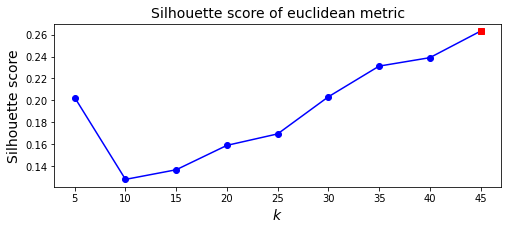

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be remo

Number of clusters -  45
Best score -  0.24294452


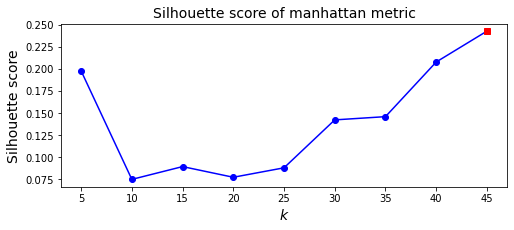

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be remo

Number of clusters -  45
Best score -  0.27001962


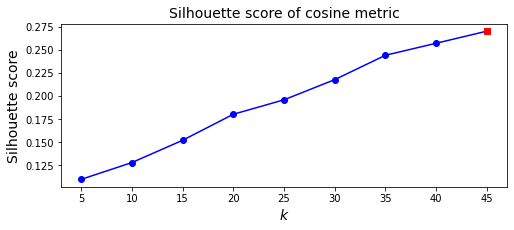

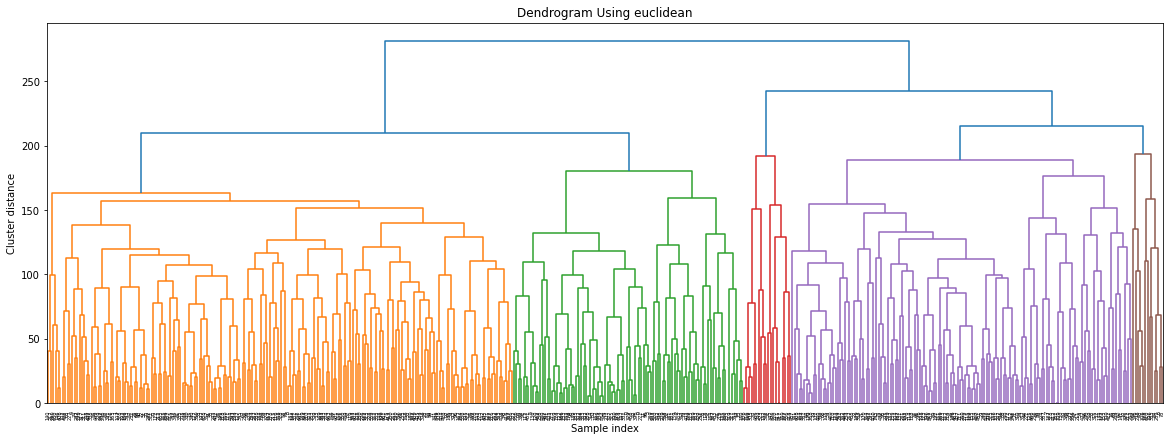

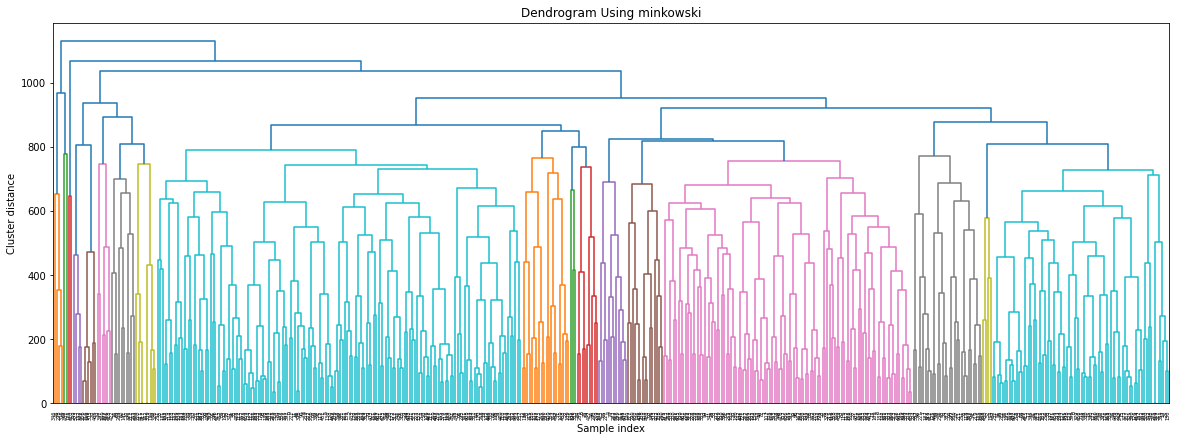

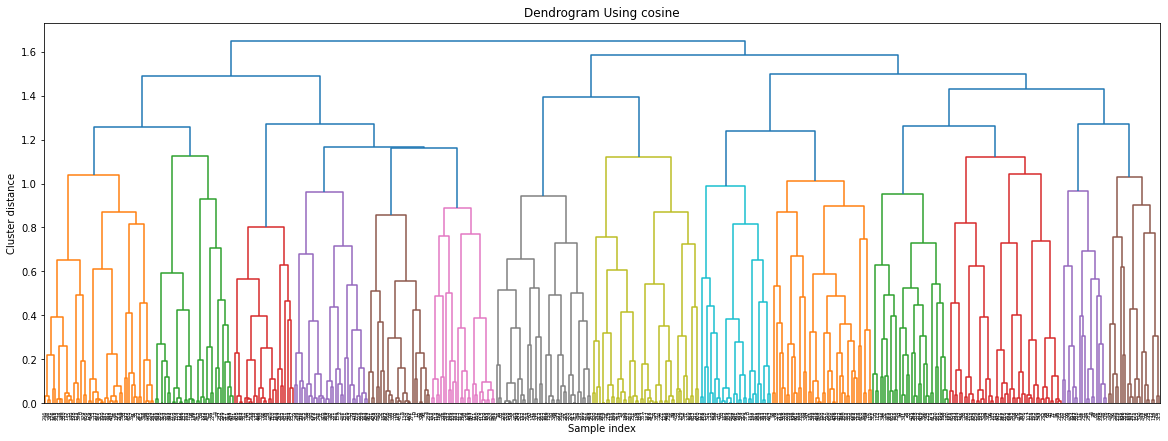

In [36]:
affinity = ['euclidean', 'manhattan', 'cosine']
dist = ['euclidean', 'minkowski', 'cosine']

agglClustering = agglExecution(x_train_pca, affinity, dist)

for i in range(len(dist)):
  plt.figure(figsize=(20, 7))
  plt.title("Dendrogram Using {}".format(dist[i]))
  plt.xlabel('Sample index')
  plt.ylabel('Cluster distance')
  if(dist[i] == 'minkowski'):
    pDist =  pdist(x_train_pca, 'minkowski', p=1)
  else:
      pDist =  pdist(x_train_pca, dist[i])
  dendro = sch.dendrogram(sch.linkage(pDist, method='complete'))
  plt.show()

In [43]:
# Train, test and validation data transform using the best k value of K-means algorithm
'''agg_train_labels = AgglomerativeCluster(x_train_pca, len(agglClustering))
agg_valid_labels = AgglomerativeCluster(x_valid_pca, len(agglClustering))
agg_test_labels = AgglomerativeCluster(x_test_pca, len(agglClustering))

print("Shape of cluster index values for train data", gc_train_labels.shape) # Output cluster index value for trained data i.e., (439,1)
print("Shape of cluster index values for valid data", gc_valid_labels.shape)
print("Shape of cluster index values for test data", gc_test_labels.shape)'''

'agg_train_labels = AgglomerativeCluster(x_train_pca, len(agglClustering))\nagg_valid_labels = AgglomerativeCluster(x_valid_pca, len(agglClustering))\nagg_test_labels = AgglomerativeCluster(x_test_pca, len(agglClustering))\n\nprint("Shape of cluster index values for train data", gc_train_labels.shape) # Output cluster index value for trained data i.e., (439,1)\nprint("Shape of cluster index values for valid data", gc_valid_labels.shape)\nprint("Shape of cluster index values for test data", gc_test_labels.shape)'

### Bisecting KMeans

Irits Anna Mathew


The BisectingKMeans is an iterative variant of KMeans, using divisive hierarchical clustering. Instead of creating all centroids at once, centroids are picked progressively based on a previous clustering: a cluster is split into two new clusters repeatedly until the target number of clusters is reached.

BisectingKMeans is more efficient than KMeans when the number the number of clusters is large since it only works on a subset of the data at each bisection while KMeans always works on the entire dataset.

In [40]:
from sklearn.cluster import BisectingKMeans
def bisectingKMeans(x):
  Bkmeans = []
  k_range_ = range(10,50,10)
  for k in k_range_:
      Bkmeans.append(BisectingKMeans(n_clusters=k, random_state=46).fit(x))

  silhouette_scores_ = [silhouette_score(x, model.labels_) for model in Bkmeans]
  best_k_value = k_range_[np.argmax(silhouette_scores_)]
  IA_best_model = Bkmeans[np.argmax(silhouette_scores_)]
  IA_best_score = silhouette_scores_[(np.argmax(silhouette_scores_))]

  print("\nBest value of k: ",best_k_value)
  print("\n", IA_best_model)

  plt.figure(figsize=(8, 3))
  plt.plot(k_range_, silhouette_scores_, "bo-")
  plt.xlabel("$k$", fontsize=14)
  plt.ylabel("Silhouette score", fontsize=14)
  plt.plot(best_k_value, IA_best_score, "rs")
  plt.show()
  return IA_best_model


Best value of k:  40

 BisectingKMeans(n_clusters=40, random_state=46)


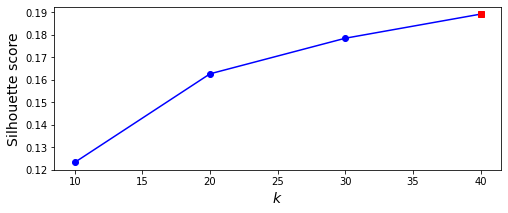

In [41]:
bisectingKMeansClustering = bisectingKMeans(x_train_pca)

In [42]:
bisectK_train_labels = bisectingKMeansClustering.labels_
bisectK_valid_labels = bisectingKMeansClustering.predict(x_valid_pca)
bisectK_test_labels = bisectingKMeansClustering.predict(x_test_pca)

print("Shape of cluster index values for train data", bisectK_train_labels.shape) # Output cluster index value for trained data i.e., (439,1)
print("Shape of cluster index values for valid data", bisectK_valid_labels.shape)
print("Shape of cluster index values for test data", bisectK_test_labels.shape)

Shape of cluster index values for train data (465,)
Shape of cluster index values for valid data (52,)
Shape of cluster index values for test data (58,)


## Clearly discuss - with illustrations - the architecture your team has selected for training and predicting the test instances. Discuss the rationale behind your team’s choice of activation functions, loss function, and how you tuned the hyperparameters of the network model. [30 points]

step to build the neural network model.

-	Build neural network model where the input is original image, where the output are the 'labels_' of clustering model for an image i.e., cluster index

o	Shape of image: (112,92,1) 
o	Flatten shape of image data: (112*92) 



In [46]:
#x_final = standardization(x_train_pca)
labels = np.unique(gc_train_labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [47]:
from keras import models, layers, losses
from keras.optimizers import Adam

def prepareModel(outputNeurons:None, learning_rate = 0.01):
  model = models.Sequential()
  model.add(layers.BatchNormalization(input_shape=(112,92,1)))
  model.add(layers.Conv2D(16, 3, activation="relu", padding="valid"))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(32, 3, activation="relu", padding="same"))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, activation="relu", padding="same"))
  #model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  
  ##model.add(layers.Dense(256, activation="relu"))
  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dense(outputNeurons, activation="softmax"))

  adam = Adam(learning_rate=learning_rate)
  mse = losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  loss = losses.SparseCategoricalCrossentropy()
  model.compile(loss=loss, optimizer=adam, metrics=["accuracy"])
  
  return model

### Train the model

In [48]:
def train(model, epochs = 20, X_train=None, y_train=None, X_valid=None, y_valid=None, X_test = None, y_test=None):
  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

  score = model.evaluate(X_test, y_test)
  print("Test accuracy score - ", score)

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  return model

### Predictions

In [49]:
def predict_(model, X_test, y_test):
  y_proba = model.predict(X_test)
  temp = np.array([np.argmax(y_proba[i]) for i in range(len(y_proba))])
  df = pd.DataFrame({'Original_Lables':y_test, 'Predicted_Labels':temp, 'Matching': y_test == temp})
  return df

### Execution

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 112, 92, 1)       4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 110, 90, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 22, 32)       0         
 2D)                                                             
                                                        

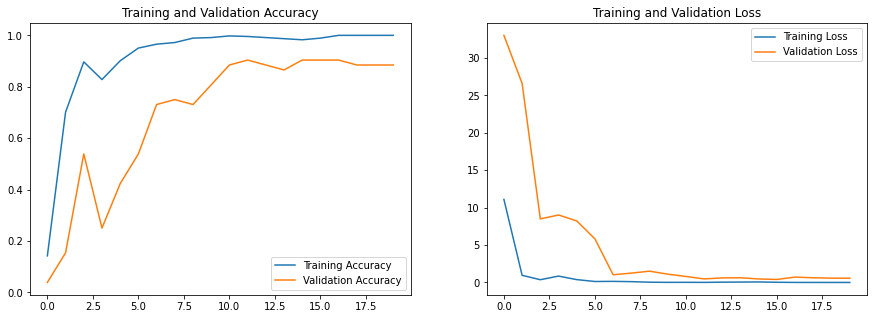

In [50]:
model = prepareModel(len(labels)) # prepareModel(outputNeurons:None, learning_rate = 0.01):
model.summary()
#train(model, epochs = 20, X_train=None, y_train=None, X_valid=None, y_valid=None, X_test = None, y_test=None)
trained_model = train(model, 
                      epochs= 20,
                      X_train = x_train.reshape(465,112,92,1),
                      y_train = gc_train_labels, 
                      X_valid = x_valid.reshape(x_valid.shape[0],112,92,1),
                      y_valid = gc_valid_labels,
                      X_test = x_test.reshape(x_test.shape[0],112,92,1),
                      y_test = gc_test_labels)

In [197]:
trained_model.save("umist.h5")

In [51]:
# Total number of test samples are 58
df = predict_(trained_model, x_test.reshape(x_test.shape[0], 112,92,1), gc_test_labels)
df[df['Matching'] == True].count()

2/2 [==============================] - 0s 6ms/step


Original_Lables     55
Predicted_Labels    55
Matching            55
dtype: int64

In [52]:
title = [f"{df['Original_Lables'][i]} : {df['Predicted_Labels'][i]}" for i in range(x_test.shape[0])]

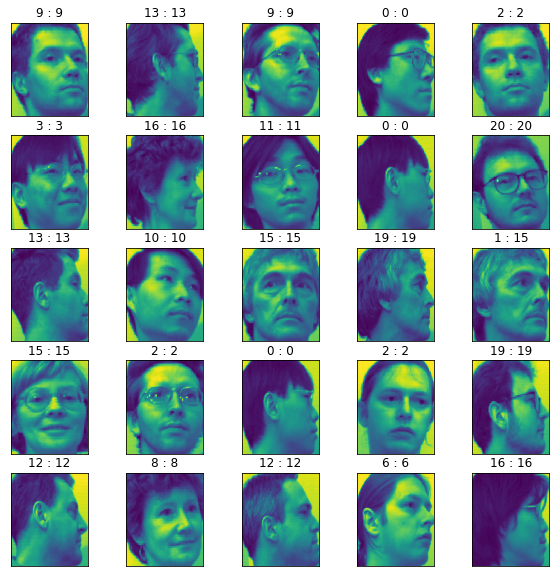

In [53]:
plotImages(x_test[:25], title)

### Hyperparameter tuning

Install the keras-tuner using pip command

In [54]:
def build_model(hp):
  model = models.Sequential()
  model.add(layers.Input(shape=(112, 92, 1)))
  for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
    filters = hp.Int('filters_' + str(i), 16, 256, step=32)
    for _ in range(2):
      model.add(layers.Convolution2D(filters, kernel_size=(3, 3), padding='same'))
      model.add(layers.BatchNormalization())
      model.add(layers.ReLU())
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      model.add(layers.MaxPool2D())
    else:
      model.add(layers.AvgPool2D())
  # Model input layer
  model.add(layers.Flatten(input_shape=(28, 28)))
  # Define the number of neurons using Int function
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(layers.Dense(units=hp_units, activation='relu'))
  model.add(layers.Dense(21, activation='softmax'))

  # Tune the learning rate for the optimizer to Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

In [56]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

tuner.search(x_train, gc_train_labels, epochs=5, validation_data=(x_valid, gc_valid_labels))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 22s]
val_loss: 14.78085994720459

Best val_loss So Far: 2.449033498764038
Total elapsed time: 00h 01m 37s


In [57]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]
print(best_hps)

# Get the best model
best_model = tuner.get_best_models()[0]

##Discuss the results of the trained system. [5 points]